In [1]:
%pylab inline

import numpy as np
from astropy.table import Table
from astropy.io import ascii
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy import sparse
from sklearn.mixture import GMM

from astroML.clustering import HierarchicalClustering, get_graph_segments

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = Table.read('breddkatalog_fluxes.csv', converters = {'col1': [ascii.convert_numpy(np.str)]})

In [3]:
name = data['Name']
width = data['W']
alpha = data['alpha'] 
epk = data['Epk'] 
t90 = data['T90']
flnc = data['Flnc']
flux = data['Pflux1024']
beta = data['beta']

In [4]:
X=np.vstack([alpha,beta]).T
print X

[[-0.8487474 -6.913354 ]
 [-0.2883679 -2.410852 ]
 [-0.8383592 -2.641696 ]
 ..., 
 [-0.6020357 -7.768634 ]
 [-1.669009  -5.889893 ]
 [ 1.023789  -8.187179 ]]


In [5]:
xmin, xmax = (-2.0, 2.0)
ymin, ymax = (-40.0, 0)


In [6]:
n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=10,
                               edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print " scale: " % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff)

n_components = model.n_components_
labels = model.labels_

 scale: 


In [7]:
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

In [8]:
Nx = 100
Ny = 250
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T
density = np.zeros(Xgrid.shape[0])

for i in range(n_components):
    ind = (labels == i)
    Npts = ind.sum()
    Nclusters = min(12, Npts / 5)

    gmm = GMM(Nclusters).fit(X[ind])
    dens = np.exp(gmm.score(Xgrid))
    density += dens / dens.max()

density = density.reshape((Ny, Nx))

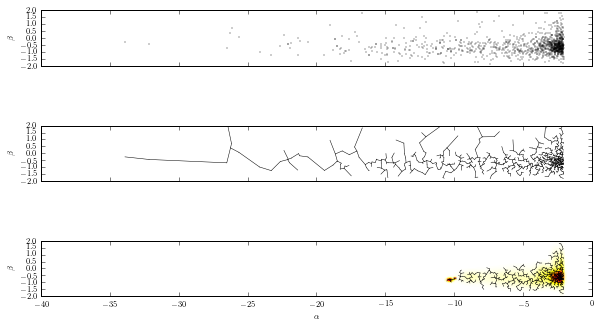

In [9]:
fig = plt.figure(figsize=(9, 6))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel(r'$\rm \beta$')

ax = fig.add_subplot(312, aspect='equal')
ax.plot(T_y, T_x, c='k', lw=0.5)
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel(r'$\rm \beta$')

ax = fig.add_subplot(313, aspect='equal')
ax.plot(T_trunc_y, T_trunc_x, c='k', lw=0.5)
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel(r'$\rm \alpha$')
ax.set_ylabel(r'$\rm \beta$')

plt.show()